Rachel Sheinberg
July 2023

Step 1: Importing Original Folders 

In [1]:
import os
import pandas as pd

# Define the root directory where your folders are located
root_directory = 'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/data/data/'

# Create an empty dictionary to store the DataFrames
df_dict = {}

# Iterate over each folder
folders = os.listdir(root_directory)
for folder_name in folders:
    folder_path = os.path.join(root_directory, folder_name)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
    
        # Get a list of files in the folder
        files = os.listdir(folder_path)
        
        # Iterate over each file in the folder
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            
            # Check if the path is a file
            if os.path.isfile(file_path):
            
                # Read the file as a DataFrame and store it in the dictionary
                key = os.path.join(folder_name, file_name)
                df = pd.read_csv(file_path)
        
                
                # Select specific columns
                selected_columns = ['timestamp',
                                   'units_represented','out.site_energy.total.energy_consumption.kwh',
                                   'out.electricity.total.energy_consumption.kwh','out.fuel_oil.total.energy_consumption.kwh',
                                   'out.natural_gas.total.energy_consumption.kwh','out.propane.total.energy_consumption.kwh',
                                    ]
                df = df[selected_columns]
               
                # Accounting for units represented to get load of single unit
                df['elec.consumed'] = df['out.electricity.total.energy_consumption.kwh'] / df['units_represented']
                df['nat_gas.consumed'] = df['out.natural_gas.total.energy_consumption.kwh'] / df['units_represented']
                df['total.consumed'] = df['out.site_energy.total.energy_consumption.kwh'] / df['units_represented']
                df['elec.load'] = df['elec.consumed'] / .25
                df['nat_gas.load'] = df['nat_gas.consumed'] / .25
                df['total_load'] = df['total.consumed'] / .25
                df_dict[key] = df
print('done')

done


Step 2: Create Dictionary for User Interface

In [2]:
# creating a dictionary to match the names i've assigned the folders to the excel values

# first get the strings from excel options
nrel = df_dict.keys()
excel_homes = ("Mobile Home", "Multi-Family 2-4 Units", "Multi-Family 5+ Units", "Single Family Attached", "Single Family Detached")
excel_upgrades = ("Baseline", "Basic Enclosure", "Enhanced Enclosure", "Heat Pumps and High Efficiency Electric Backup",
                  "Heat Pumps and Min Efficiency Electric Backup","Heat Pumps and Min Efficiency, Existing Heating as Backup",
                  "Heat Pump Water Heaters", "Whole Home Electrification High Efficiency", "Whole Home Electrification High Efficiency Plus Basic Enclosure Package",
                  "Whole Home Electrification High Efficiency Plus Enhanced Enclosure Package", "Whole Home Electrification Min Efficiency")

# Creating a third list by concatenating strings from list1 and list2
excel = []
for string1 in excel_upgrades:
    for string2 in excel_homes:
        excel.append(string1 + ": " + string2)
        
# Creating a dictionary using a loop and zip()
excel_to_nrel = {}
for excel, nrel in zip(excel, nrel):
    excel_to_nrel[excel] = nrel

## I now have a dictionary to transfer from excel to the file name, and a dictionary to tranfer from the file name to values 
## within that file! 

Step 3: Import Data from Current Interface Type (Excel Spreadsheet) 

In [3]:
file_path = r'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/electric_calculator.xlsm'
# Read Dataframe from Excel file
inputs = pd.read_excel(file_path, sheet_name='Python')

In [4]:
# selecting the correct files from user input -- using dictionary 
start = str(inputs.iloc[1,1]) + ": " + str(inputs.iloc[0,1]) ## combining starting electrification and home type
upgrade = str(inputs.iloc[2,1]) + ": " + str(inputs.iloc[0,1]) ## combining upgrade and home type
upgrade_only = str(inputs.iloc[2,1])
nrel_start = excel_to_nrel[start] ## translate to nrel filename
start_data = df_dict[nrel_start] ## select data from the dictionary 
nrel_upgrade = excel_to_nrel[upgrade] ## translate to nrel filename
upgrade_data = df_dict[nrel_upgrade] ## select data from the dictionary 

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

# Retrieve the column data from the four columns I care about here for the starting  loads 
timestamps = pd.to_datetime(start_data['timestamp'])
start_elec_values = start_data['elec.consumed']
start_gas_values = start_data['nat_gas.consumed']
start_total_values = start_data['total.consumed']
start_elec_load = start_data['elec.load']

# Retrieve the column data from the four columns i care about here - ending loads
upgrade_timestamps = pd.to_datetime(upgrade_data['timestamp'])
upgrade_elec_values = upgrade_data['elec.consumed']
upgrade_gas_values = upgrade_data['nat_gas.consumed']
upgrade_total_values = upgrade_data['total.consumed']
upgrade_elec_load = upgrade_data['elec.load']

In [6]:
## normalizing starting values
total = sum(start_elec_values)  # Calculate the sum of all values
scaled_start_elec_values = [x/total for x in start_elec_values]  # Scale each value
total = sum(start_gas_values)  # Calculate the sum of all values
scaled_start_gas_values = [x/total for x in start_gas_values]  # Scale each value
total = sum(start_total_values)  # Calculate the sum of all values
scaled_start_total_values = [x/total for x in start_total_values]  # Scale each value
total = sum(start_elec_load) 
scaled_start_elec_load = [x/total for x in start_elec_load]

## normalizing upgrade values
total = sum(upgrade_elec_values)  # Calculate the sum of all values
scaled_upgrade_elec_values = [x/total for x in upgrade_elec_values]  # Scale each value
total = sum(upgrade_gas_values)  # Calculate the sum of all values
scaled_upgrade_gas_values = [x/total for x in upgrade_gas_values]  # Scale each value
total = sum(upgrade_total_values)  # Calculate the sum of all values
scaled_upgrade_total_values = [x/total for x in upgrade_total_values]  # Scale each value
total = sum(upgrade_elec_load) 
scaled_upgrade_elec_load = [x/total for x in upgrade_elec_load]

Step 4: Scale up with User Inputs

In [7]:
file_path = r'C:\Users\Rachel\OneDrive - UCLA IT Services\Documents\DWP_Electrification_Cal\Multipliers.csv'
multipliers = pd.read_csv(file_path) ## using multipliers between starting and ending upgrade status
multiplier_key = nrel_start + "\\" + nrel_upgrade.split("\\")[0] ## identify correct multiplier based on user inputs

In [8]:
 #identify specific multipliers for the user-entered combination, based on start and end type and elec and nat gas usage
vals = multipliers[multipliers['name'] == multiplier_key] ## multipliers based on start type --> end type 

# create multipliers based on user inputted annual energy use
start_elec_mult = float(inputs.iloc[3,1]) ## user inputted electricity usage
upgrade_elec_mult = float(inputs.iloc[3,1] * vals['elec_mult'].iloc[0]) ## user inputted usage multiplied for upgrade type
start_nat_gas_mult = float(inputs.iloc[4,1]*29.3) ## user inputted natural gas usage
upgrade_nat_gas_mult = float(inputs.iloc[4,1]*29.3 * vals['nat_gas_mult'].iloc[0]) ## user inputted usage multiplied for upgrade type
start_total_mult = float(inputs.iloc[3,1]+ inputs.iloc[4,1]*29.3) ## total usage, sum of electricity inputted and natural gas; translating natural gas therms to kwh 
upgrade_total_mult = float((inputs.iloc[3,1]+inputs.iloc[4,1]*29.3) * vals['total_mult'].iloc[0]) ## total usage multiplied for upgrade type
start_elec_load_mult = float(inputs.iloc[3,1]*4) ## user inputted electricity usage divided by hours in the year to get load
upgrade_elec_load_mult = float(inputs.iloc[3,1]*4*vals['elec_mult'].iloc[0]) ## elec load multiplied for upgrade type 

In [9]:
## Create a new dataframe containing scaled up values for the starting and ending upgrade statuses 

start_elec_vals = [x * start_elec_mult for x in scaled_start_elec_values] ## starting electricity usage
upgrade_elec_vals = [x * upgrade_elec_mult for x in scaled_upgrade_elec_values] ## upgrade electricity usage
start_nat_gas_vals = [x * start_nat_gas_mult for x in scaled_start_gas_values] ## starting natural gas usage
upgrade_nat_gas_vals = [x * upgrade_nat_gas_mult for x in scaled_upgrade_gas_values] ## upgrade natural gas usage
start_total_vals = [x * start_total_mult for x in scaled_start_total_values] ## starting total usage
upgrade_total_vals = [x * upgrade_total_mult for x in scaled_upgrade_total_values] ## upgrage total usage
start_elec_load = [x * start_elec_load_mult for x in scaled_start_elec_load]
upgrade_elec_load = [x * upgrade_elec_load_mult for x in scaled_upgrade_elec_load]
df = pd.DataFrame({
    'Timestamps': timestamps,
    'start_elec_vals': start_elec_vals,
    'upgrade_elec_vals': upgrade_elec_vals,
    'start_nat_gas_vals': start_nat_gas_vals,
    'upgrade_nat_gas_vals': upgrade_nat_gas_vals,
    'start_total_vals': start_total_vals,
    'upgrade_total_vals': upgrade_total_vals,
    'start_elec_load' : start_elec_load,
    'upgrade_elec_load' : upgrade_elec_load
    
})


Step 6: Plot the Energy use before and after upgrade

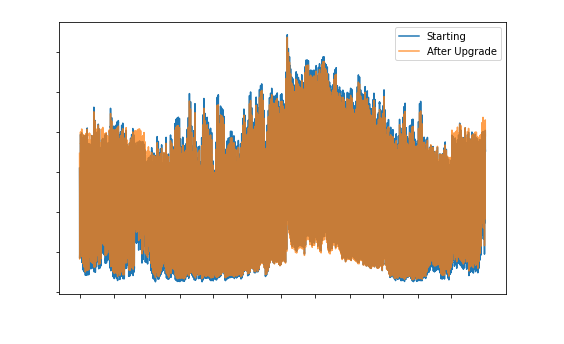

In [10]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_elec_vals)
plt.plot(timestamps, upgrade_elec_vals, alpha = 0.75)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Electricity Usage - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])
plt.show()

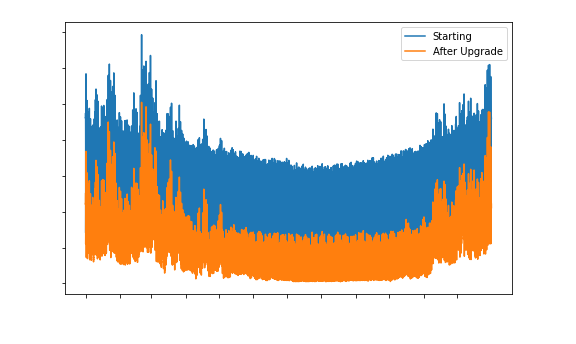

In [11]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_nat_gas_vals)
plt.plot(timestamps, upgrade_nat_gas_vals)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Natural Gas Usage - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])           
plt.show()

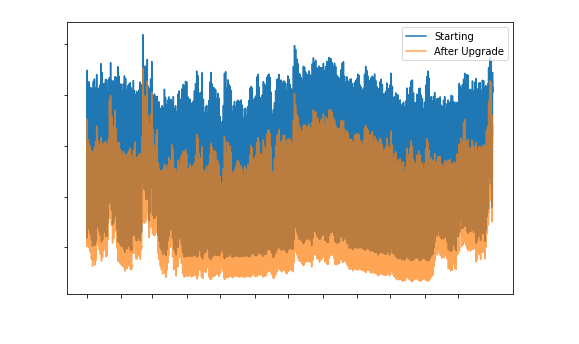

In [12]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_total_vals)
plt.plot(timestamps, upgrade_total_vals, alpha = 0.7)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Total Energy Usage - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])
plt.show()

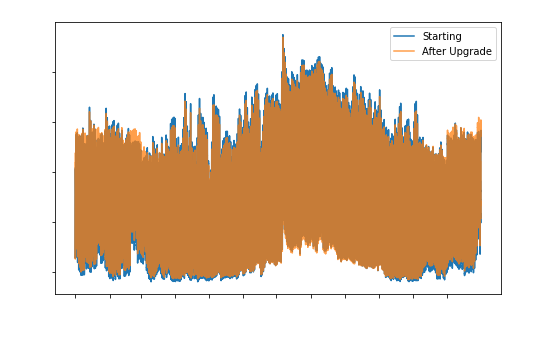

In [13]:
# Plotting the natural gas use before and after 
fig = plt.figure(figsize=(8, 5))
plt.plot(timestamps, start_elec_load)
plt.plot(timestamps, upgrade_elec_load, alpha = 0.75)
plt.xlabel('Date', color = 'white')
plt.ylabel('Usage (kWh)', color = 'white')
plt.title('Household Electricity Load - ' + start + " vs. " + upgrade_only, color = 'white')

#Set the tick locations and labels for the horizontal axis
tick_positions = pd.date_range(start=min(timestamps), end=max(timestamps), freq='MS')
months = tick_positions.strftime('%b')
plt.xticks(tick_positions, months)

# Rotate the tick labels if needed
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.legend(['Starting', 'After Upgrade'])
plt.show()

In [14]:
## Creating a new dataframe to hold the energy values and add in cost values
# Make sure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['Timestamps'])

# Set the 'datetime' column as the index for easier grouping by month
df.set_index('datetime', inplace=True)

# Resample the data to monthly frequency and calculate the sum for each set of data
monthly_sums = df.resample('M').sum()

# Reset the index to get the 'Timestamps' column back as a regular column
monthly_sums.reset_index(inplace=True)
monthly_sums['start_elec_cost'] = 0
monthly_sums['upgrade_elec_cost'] = 0

print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       245.483577         253.918728         1020.886863   
1  2018-02-28       221.886414         229.349965          916.221898   
2  2018-03-31       229.085062         234.632802          934.981919   
3  2018-04-30       229.845605         228.594793          779.958058   
4  2018-05-31       235.405429         233.727805          757.024228   
5  2018-06-30       254.584940         249.360354          667.471529   
6  2018-07-31       308.668873         300.645353          650.054966   
7  2018-08-31       302.041106         294.160088          651.747919   
8  2018-09-30       263.894268         257.411047          662.402809   
9  2018-10-31       244.356831         240.432656          746.068736   
10 2018-11-30       222.241030         225.656030          848.258079   
11 2018-12-31       242.396162         252.472070         1033.463993   
12 2019-01-31         0.110704           0.118043  

Vehicle Pricing and load

Calculate Pre-Transition Fuel Cost 

In [15]:
print(inputs)

                                     Vars                   Inputs
0                            Type of Home    Multi-Family 5+ Units
1                     Current Home Status                 Baseline
2                Upgrage Scenario to Test  Heat Pump Water Heaters
3          Annual Electricity Usage (kWh)                     3000
4       Annual Natural Gas Usage (Therm)                       330
5                           Customer Zone                        1
6   Customer Annual Household Income ($)                     50000
7                Customer Assistance Rate                     None
8             Natural Gas Assistance Rate                     None
9              Electricity Rate Structure   Three Tiered (Current)
10              Gasoline Price ($/Gallon)                      4.8
11    Natural Gas Increase Above Baseline                        0
12                 Current Upgrade Status                     None
13                       Upgrade to Test                      

In [16]:
current_car = inputs.iloc[14,1]
vmt = inputs.iloc[16,1] if inputs.iloc[16,1] != 0 else 10000
current_mpg = inputs.iloc[15,1]
gas_price = inputs.iloc[10,1]
if current_car == 'None':
    start_gas_cost = 0
elif current_car == 'Gasoline Car/Sedan' or current_car == 'Gasoline Light Truck/Van/SUV':
    ## cost before EV 
    gas_consumed = vmt/current_mpg
    start_gas_cost = gas_price * gas_consumed
else: 
    start_gas_cost = 0 
    ## assuming electric cost is already baked in via load 
start_daily_gas_cost = start_gas_cost/365

Calculate Post-Transition Fuel Cost

In [17]:
## assessing load based on if transition includes upgrade to EV 
ev_mpge = 93 if current_car == "Gasoline Light Truck/Van/SUV" else 93
transition = inputs.iloc[13,1]
if transition == 'None':
    upgrade_gas_cost = start_gas_cost
    e_trans_consumed = 0 
    e_trans_consumed_daily = 0 
elif transition == 'Solar PV':
    upgrade_gas_cost = start_gas_cost
    e_trans_consumed = 0
    e_trans_consumed_daily = 0 
else:
    upgrade_gas_cost = 0
    ge_consumed = vmt/ev_mpge
    e_trans_consumed = ge_consumed * 33.7 ## assuming 1 gallon equivalent ~ 33.7 kWh
    e_trans_consumed_daily = e_trans_consumed/365
upgrade_daily_gas_cost = upgrade_gas_cost/365

## assessing load and cost based on charging behavior 
ev_charging = inputs.iloc[17,1]
### residential charging 
if ev_charging == "Residential/Overnight":
    charge_hours = e_trans_consumed_daily/7.6 #assuming charge rate is 7.6 kW 
    trans_charge_load = e_trans_consumed_daily/charge_hours ## this will be useful for TOU pricing, not using for now
    e_trans_cost_daily = 0 
    ### non-residential charging
elif ev_charging == 'Public or Workplace/Daytime Level 2': 
    e_trans_cost_daily = e_trans_consumed_daily * 0.29 ## assuming $0.29 per kwh
    e_trans_consumed_daily = 0 
elif ev_charging == 'Public or Workplace/Daytime DCFC': 
    e_trans_cost_daily = e_trans_consumed_daily * 0.42 ## assuming $0.42 per kwh
    e_trans_consumed_daily = 0 
else: 
    e_trans_cost_daily = 0 
    e_trans_consumed_daily = 0 
## making an array to add on to monthly sums 
# Define the number of days in each month
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,365]
## start electric cost will always be zero -- assumed to be included in the load
## will just need to add upgrade electric load, upgrade electric cost, start and upgrade gas cost
start_gas_cost = np.array(days_in_month) * start_daily_gas_cost
upgrade_gas_cost = np.array(days_in_month) * upgrade_daily_gas_cost
upgrade_res_ev_elec = np.array(days_in_month) * e_trans_consumed_daily
upgrade_res_ev_cost = np.array(days_in_month) * e_trans_cost_daily
print(upgrade_res_ev_elec)   
print(upgrade_res_ev_cost)
print(start_gas_cost)
print(upgrade_gas_cost)

[ 307.76255708  277.97908381  307.76255708  297.83473266  307.76255708
  297.83473266  307.76255708  307.76255708  297.83473266  307.76255708
  297.83473266  307.76255708 3623.65591398]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 163.06849315  147.28767123  163.06849315  157.80821918  163.06849315
  157.80821918  163.06849315  163.06849315  157.80821918  163.06849315
  157.80821918  163.06849315 1920.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Add EV load to the upgrade electricity load

In [18]:
monthly_sums['upgrade_elec_vals'] = monthly_sums['upgrade_elec_vals'] + upgrade_res_ev_elec
print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       245.483577         561.681285         1020.886863   
1  2018-02-28       221.886414         507.329048          916.221898   
2  2018-03-31       229.085062         542.395359          934.981919   
3  2018-04-30       229.845605         526.429526          779.958058   
4  2018-05-31       235.405429         541.490362          757.024228   
5  2018-06-30       254.584940         547.195086          667.471529   
6  2018-07-31       308.668873         608.407910          650.054966   
7  2018-08-31       302.041106         601.922645          651.747919   
8  2018-09-30       263.894268         555.245780          662.402809   
9  2018-10-31       244.356831         548.195213          746.068736   
10 2018-11-30       222.241030         523.490762          848.258079   
11 2018-12-31       242.396162         560.234627         1033.463993   
12 2019-01-31         0.110704        3623.773957  

Step 6: Calculate Electricity and Natural Gas Costs Before and After Upgrade

6.1 Electricity pricing 

In [19]:
file_path = r'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/electric_pricing.xlsx'
# Read Dataframe from Excel file of electricity prices 
elec_prices = pd.read_excel(file_path, sheet_name='resi')

In [20]:
##  Assigning each of the months a tier value based on zone and usage
## Use tier value to choose associated power access charge and energy charge, multiplied by usage
zone = int(inputs.iloc[5,1])
for x in range(12):
    start_elec_usage = monthly_sums['start_elec_vals'].iloc[x]
    upgrade_elec_usage = monthly_sums['upgrade_elec_vals'].iloc[x]
    if zone == 1:
        if start_elec_usage <= 350:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En Charge T1'].iloc[x]*start_elec_usage
        elif start_elec_usage <= 1050:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*350 + elec_prices['En Charge T2'].iloc[x]*(start_elec_usage-350)
        else: 
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*350 + elec_prices['En Charge T2'].iloc[x]*700 + elec_prices['En Charge T3'].iloc[x]*(start_elec_usage-1050)
        if upgrade_elec_usage <= 350:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En Charge T1'].iloc[x]*upgrade_elec_usage
        elif upgrade_elec_usage <= 1050:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] +  \
            elec_prices['En Charge T1'].iloc[x]*350 + elec_prices['En Charge T2'].iloc[x]*(upgrade_elec_usage-350)
        else: 
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*350 + elec_prices['En Charge T2'].iloc[x]*700 + elec_prices['En Charge T3'].iloc[x]*(upgrade_elec_usage-1050)
    else: 
        if elec_usage <= 500:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En Charge T1'].iloc[x]*start_elec_usage
        elif elec_usage <= 1500:
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*500 + elec_prices['En Charge T2'].iloc[x]*(start_elec_usage-500)
        else: 
            monthly_sums['start_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*500 + elec_prices['En Charge T2'].iloc[x]*1000 + elec_prices['En Charge T3'].iloc[x]*(start_elec_usage-1500)
        if upgrade_elec_usage <= 500:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T1'].iloc[x] + elec_prices['En Charge T1'].iloc[x]*upgrade_elec_usage
        elif upgrade_elec_usage <=1500:
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T2'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*500 + elec_prices['En Charge T2'].iloc[x]*(upgrade_elec_usage-500)
        else: 
            monthly_sums['upgrade_elec_cost'].iloc[x] = elec_prices['Cust Charge T3'].iloc[x] + \
            elec_prices['En Charge T1'].iloc[x]*500 + elec_prices['En Charge T2'].iloc[x]*1000 + elec_prices['En Charge T3'].iloc[x]*(upgrade_elec_usage-1500)

C:\Users\Rachel\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
## accounting for lifeline or EZ-Save, Utility Users Tax (UUT)
if inputs.iloc[7,1] == 'Lifeline':
    monthly_sums['start_elec_cost'] = monthly_sums['start_elec_cost'] - 17.71 ## no UUT, Lifeline discount
    monthly_sums['upgrade_elec_cost'] = monthly_sums['upgrade_elec_cost'] - 17.71 ## no UUT, Lifeline discount
elif inputs.iloc[7,1] == 'EZ-Save':
    monthly_sums['start_elec_cost'] = (monthly_sums['start_elec_cost'] - 8.17)*1.1 ## adding UUT, EZ-Save discount
    monthly_sums['upgrade_elec_cost'] = (monthly_sums['upgrade_elec_cost'] - 8.17)*1.1 ## adding UUT, EZ-Save discount
else: 
    monthly_sums['start_elec_cost'] = monthly_sums['start_elec_cost']*1.1 ## adding UUT, no discount
    monthly_sums['upgrade_elec_cost'] = monthly_sums['upgrade_elec_cost'] *1.1 ## adding UUT, no discount

#remove the extraneous row 
monthly_sums = monthly_sums.iloc[:-1,:]

# create yearly sums from all of the months 
sum_row = monthly_sums.iloc[:, 1:].sum(numeric_only=True)
monthly_sums = monthly_sums.append(sum_row, ignore_index = True)


print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       245.483577         561.681285         1020.886863   
1  2018-02-28       221.886414         507.329048          916.221898   
2  2018-03-31       229.085062         542.395359          934.981919   
3  2018-04-30       229.845605         526.429526          779.958058   
4  2018-05-31       235.405429         541.490362          757.024228   
5  2018-06-30       254.584940         547.195086          667.471529   
6  2018-07-31       308.668873         608.407910          650.054966   
7  2018-08-31       302.041106         601.922645          651.747919   
8  2018-09-30       263.894268         555.245780          662.402809   
9  2018-10-31       244.356831         548.195213          746.068736   
10 2018-11-30       222.241030         523.490762          848.258079   
11 2018-12-31       242.396162         560.234627         1033.463993   
12        NaT      2999.889296        6624.017604  

In [22]:
### adding in fuel cost 
monthly_sums['start_external_fuel_cost'] = start_gas_cost
monthly_sums['upgrade_external_fuel_cost'] = upgrade_res_ev_cost + upgrade_gas_cost
print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       245.483577         561.681285         1020.886863   
1  2018-02-28       221.886414         507.329048          916.221898   
2  2018-03-31       229.085062         542.395359          934.981919   
3  2018-04-30       229.845605         526.429526          779.958058   
4  2018-05-31       235.405429         541.490362          757.024228   
5  2018-06-30       254.584940         547.195086          667.471529   
6  2018-07-31       308.668873         608.407910          650.054966   
7  2018-08-31       302.041106         601.922645          651.747919   
8  2018-09-30       263.894268         555.245780          662.402809   
9  2018-10-31       244.356831         548.195213          746.068736   
10 2018-11-30       222.241030         523.490762          848.258079   
11 2018-12-31       242.396162         560.234627         1033.463993   
12        NaT      2999.889296        6624.017604  

Plot monthly bill cost 

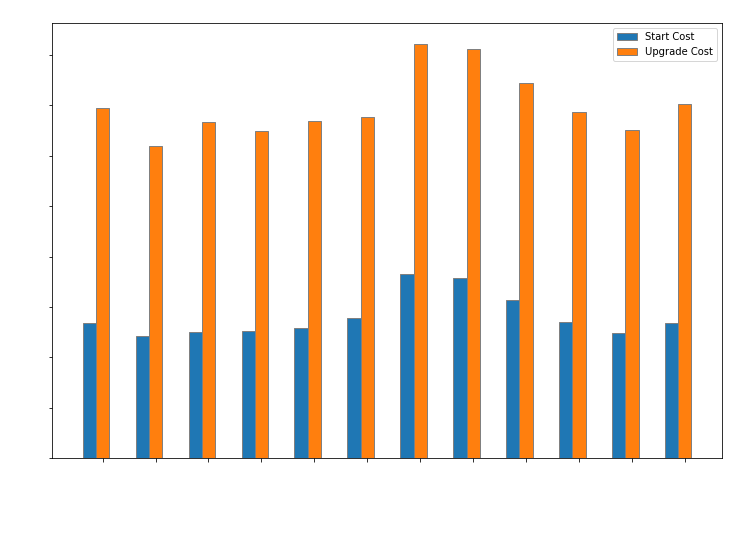

In [23]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
starting_cost = monthly_sums['start_elec_cost'][:-1]
upgrade_cost = monthly_sums['upgrade_elec_cost'][:-1]

 
# Set position of bar on X axis
br1 = np.arange(len(starting_cost))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, starting_cost, width = barWidth,
        edgecolor ='grey', label ='Start Cost')
plt.bar(br2, upgrade_cost,  width = barWidth,
        edgecolor ='grey', label ='Upgrade Cost')
 
# Adding Xticks
plt.xlabel('Month', fontweight ='bold', fontsize = 12, color = 'white')
plt.ylabel('Cost ($)', fontweight ='bold', fontsize = 15, color = 'white')
plt.xticks([r + barWidth for r in range(len(starting_cost))],
        ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December'])

plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.title('Monthly Electricity Cost - ' + start + " vs. " + upgrade_only, fontweight = 'bold', color = 'white')
plt.legend()
plt.show()

In [24]:
from prettytable import PrettyTable
table = PrettyTable()
column_names = ["Month", "Bill Pre Upgrade", "Bill After Upgrade"]
data_columns =[
     ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December','Total'],
    monthly_sums['start_elec_cost'],
    monthly_sums['upgrade_elec_cost']
    ]
# Add columns to the table
for name, data in zip(column_names, data_columns):
    table.add_column(name, data)

# Align columns to the left
for name in column_names:
    table.align[name] = "l"

# Format the salary column as dollars and cents
starting_column_index = column_names.index('Bill Pre Upgrade')
for row in table._rows:
    row[starting_column_index] = "${:.2f}".format(float(row[starting_column_index]))
    
# Format the salary column as dollars and cents
upgrade_column_index = column_names.index('Bill After Upgrade')
for row in table._rows:
    row[upgrade_column_index] = "${:.2f}".format(float(row[upgrade_column_index]))
    
# Add a horizontal line after the header row
table.horizontal_char = '-'

# Add a vertical line between columns
table.vertical_char = '|'

# Add an intersection character between the columns and the header row
table.junction_char = '+'

# Print the table
print(table)

+-----------+------------------+--------------------+
| Month     | Bill Pre Upgrade | Bill After Upgrade |
+-----------+------------------+--------------------+
| January   | $53.45           | $138.84            |
| February  | $48.56           | $124.06            |
| March     | $50.05           | $133.60            |
| April     | $50.46           | $129.84            |
| May       | $51.62           | $133.95            |
| June      | $55.62           | $135.50            |
| July      | $73.09           | $164.43            |
| August    | $71.58           | $162.53            |
| September | $62.86           | $148.85            |
| October   | $54.12           | $137.19            |
| November  | $49.45           | $130.39            |
| December  | $53.70           | $140.51            |
| Total     | $674.54          | $1679.68           |
+-----------+------------------+--------------------+


In [25]:
### calculating energy burden 
income = inputs.iloc[6,1]
start_elec_cost = monthly_sums['start_elec_cost'].iloc[12]
upgrade_elec_cost = monthly_sums['upgrade_elec_cost'].iloc[12]
start_burden = start_elec_cost/income
upgrade_burden = upgrade_elec_cost/income
formatted_start_burden  = "{:.2%}".format(start_burden)
formatted_upgrade_burden = "{:.2%}".format(upgrade_burden)
print("Customer energy burden before upgrade is: " + formatted_start_burden + ".")
print("Customer energy burden after upgrade is: " + formatted_upgrade_burden + ".")

Customer energy burden before upgrade is: 1.35%.
Customer energy burden after upgrade is: 3.36%.


Next Step: Natural Gas Pricing 

In [26]:
file_path = r'C:/Users/Rachel/OneDrive - UCLA IT Services/Documents/DWP_Electrification_Cal/ng_pricing_res.xlsx'
# Read Dataframe from Excel file
gas_prices = pd.read_excel(file_path, sheet_name='Residential')
print(gas_prices)

        Month  Days  Customer Charge  Baseline Allowance Z1  \
0     January    30          4.93140                 48.000   
1    February    28          4.60264                 44.800   
2       March    31          5.09578                 27.094   
3       April    30          4.93140                 26.220   
4         May    31          5.09578                 13.144   
5        June    30          4.93140                 12.720   
6        July    31          5.09578                 13.144   
7      August    31          5.09578                 13.144   
8   September    30          4.93140                 12.720   
9     October    31          5.09578                 13.144   
10   November    30          4.93140                 26.220   
11   December    31          5.09578                 49.600   

    Baseline Procurement_Transmission  Non-Baseline Procurement_Transmission  \
0                             1.33391                                1.77923   
1                   

In [27]:
print(inputs)

                                     Vars                   Inputs
0                            Type of Home    Multi-Family 5+ Units
1                     Current Home Status                 Baseline
2                Upgrage Scenario to Test  Heat Pump Water Heaters
3          Annual Electricity Usage (kWh)                     3000
4       Annual Natural Gas Usage (Therm)                       330
5                           Customer Zone                        1
6   Customer Annual Household Income ($)                     50000
7                Customer Assistance Rate                     None
8             Natural Gas Assistance Rate                     None
9              Electricity Rate Structure   Three Tiered (Current)
10              Gasoline Price ($/Gallon)                      4.8
11    Natural Gas Increase Above Baseline                        0
12                 Current Upgrade Status                     None
13                       Upgrade to Test                      

In [28]:
### uut for gas for LA city = 8.92% 
monthly_sums['start_nat_gas_cost'] = 0
monthly_sums['upgrade_nat_gas_cost'] = 0
gas_tax = 1.0892 ## 8.92% as taken from my old bills -- muni code says 10%, but i think it's because of some restructuring breakdown that its 8.92 instead, only applied to per therm charge
for x in range(12):
    baseline = gas_prices['Baseline Allowance Z1'].iloc[x]
    start_nat_gas_usage = monthly_sums['start_nat_gas_vals'].iloc[x]/29.3
    upgrade_nat_gas_usage = monthly_sums['upgrade_nat_gas_vals'].iloc[x]/29.3
    ## option 1 - no CARE or lifeline; pay full tax and cost 
    if inputs.iloc[8,1] == 'None'and (inputs.iloc[7,1] == 'None' or inputs.iloc[7,1] == 'EZ-Save'):
        if start_nat_gas_usage <= baseline:
            monthly_sums['start_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*start_nat_gas_usage +  gas_prices['PPPG'].iloc[x]*start_nat_gas_usage)
        else: 
            monthly_sums['start_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline \
                                                                                        + gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(start_nat_gas_usage - baseline) + gas_prices['PPPG'].iloc[x]*start_nat_gas_usage)
        if upgrade_nat_gas_usage <= baseline:
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*upgrade_nat_gas_usage + gas_prices['PPPG'].iloc[x]*upgrade_nat_gas_usage)
        else: 
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline  \
                                                                                        + gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(upgrade_nat_gas_usage - baseline) + gas_prices['PPPG'].iloc[x]*upgrade_nat_gas_usage)
    ## option 2 - No CARE but lifeline, full cost but no tax 
    elif inputs.iloc[8,1] == 'None'and inputs.iloc[7,1] == 'Lifeline':
        if start_nat_gas_usage <= baseline:
            monthly_sums['start_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*start_nat_gas_usage +  gas_prices['PPPG'].iloc[x]*start_nat_gas_usage)
        else: 
            monthly_sums['start_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline \
                                                                                        + gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(start_nat_gas_usage - baseline) + gas_prices['PPPG'].iloc[x]*start_nat_gas_usage)
        if upgrade_nat_gas_usage <= baseline:
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*upgrade_nat_gas_usage + gas_prices['PPPG'].iloc[x]*upgrade_nat_gas_usage)
        else: 
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline \
                                                                                        + gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(upgrade_nat_gas_usage - baseline) + gas_prices['PPPG'].iloc[x]*upgrade_nat_gas_usage)
                                                                                                 
    ## option 3 = CARE but no lifeline, discount but pays tax
    elif inputs.iloc[8,1] == 'CARE' and (inputs.iloc[7,1] == 'None' or inputs.iloc[7,1] == 'EZ-Save'):
        if start_nat_gas_usage <= baseline:
            monthly_sums['start_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*start_nat_gas_usage + gas_prices['PPPG - CARE'].iloc[x]*start_nat_gas_usage)) * .8
        else:
            monthly_sums['start_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline \
                                                                                        + gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(start_nat_gas_usage - baseline) + gas_prices['PPPG - CARE'].iloc[x]*start_nat_gas_usage))*.8                                              
        if upgrade_nat_gas_usage <= baseline:
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*upgrade_nat_gas_usage + gas_prices['PPPG - CARE'].iloc[x]*upgrade_nat_gas_usage)) * .8
        else: 
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + gas_tax*(gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline  +  \
                                                                                         gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(upgrade_nat_gas_usage - baseline) + gas_prices['PPPG- CARE'].iloc[x]*upgrade_nat_gas_usage))*.8
    ## option 4 - CARE and lifeline, discount and no tax 
    else:
        if start_nat_gas_usage <= baseline:
            monthly_sums['start_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*start_nat_gas_usage + gas_prices['PPPG - CARE'].iloc[x]*start_nat_gas_usage)) * .8
        else:
            monthly_sums['start_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline \
                                                                                        + gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(start_nat_gas_usage - baseline) + gas_prices['PPPG - CARE'].iloc[x]*start_nat_gas_usage))*.8 
        if upgrade_nat_gas_usage <= baseline:
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*upgrade_nat_gas_usage + gas_prices['PPPG - CARE'].iloc[x]*upgrade_nat_gas_usage)) * .8
        else: 
            monthly_sums['upgrade_nat_gas_cost'].iloc[x] = (gas_prices['Customer Charge'].iloc[x] + (gas_prices['Baseline Procurement_Transmission'].iloc[x]*baseline  +  \
                                                                                         gas_prices['Non-Baseline Procurement_Transmission'].iloc[x]*(upgrade_nat_gas_usage - baseline) + gas_prices['PPPG- CARE'].iloc[x]*upgrade_nat_gas_usage))*.8
    monthly_sums['upgrade_nat_gas_cost'].iloc[x] = 0 if monthly_sums['upgrade_nat_gas_cost'].iloc[x] <= 8 else monthly_sums['upgrade_nat_gas_cost'].iloc[x]
    monthly_sums['upgrade_nat_gas_cost'].iloc[x] = 0 if monthly_sums['upgrade_nat_gas_cost'].iloc[x] <= 8 else monthly_sums['upgrade_nat_gas_cost'].iloc[x]
monthly_sums['start_nat_gas_cost'].iloc[12] = monthly_sums['start_nat_gas_cost'].iloc[0:11].sum()
monthly_sums['upgrade_nat_gas_cost'].iloc[12] = monthly_sums['upgrade_nat_gas_cost'].iloc[0:11].sum()
print(monthly_sums)

     datetime  start_elec_vals  upgrade_elec_vals  start_nat_gas_vals  \
0  2018-01-31       245.483577         561.681285         1020.886863   
1  2018-02-28       221.886414         507.329048          916.221898   
2  2018-03-31       229.085062         542.395359          934.981919   
3  2018-04-30       229.845605         526.429526          779.958058   
4  2018-05-31       235.405429         541.490362          757.024228   
5  2018-06-30       254.584940         547.195086          667.471529   
6  2018-07-31       308.668873         608.407910          650.054966   
7  2018-08-31       302.041106         601.922645          651.747919   
8  2018-09-30       263.894268         555.245780          662.402809   
9  2018-10-31       244.356831         548.195213          746.068736   
10 2018-11-30       222.241030         523.490762          848.258079   
11 2018-12-31       242.396162         560.234627         1033.463993   
12        NaT      2999.889296        6624.017604  

C:\Users\Rachel\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


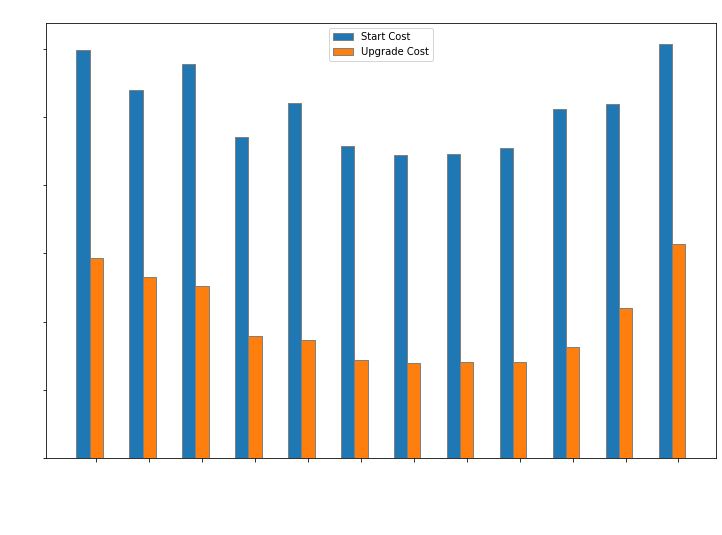

In [29]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
starting_cost = monthly_sums['start_nat_gas_cost'][:-1]
upgrade_cost = monthly_sums['upgrade_nat_gas_cost'][:-1]

 
# Set position of bar on X axis
br1 = np.arange(len(starting_cost))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, starting_cost, width = barWidth,
        edgecolor ='grey', label ='Start Cost')
plt.bar(br2, upgrade_cost,  width = barWidth,
        edgecolor ='grey', label ='Upgrade Cost')
 
# Adding Xticks
plt.xlabel('Month', fontweight ='bold', fontsize = 12, color = 'white')
plt.ylabel('Cost ($)', fontweight ='bold', fontsize = 15, color = 'white')
plt.xticks([r + barWidth for r in range(len(starting_cost))],
        ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December'])

plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.title('Monthly Natural Gas Cost - ' + start + " vs. " + upgrade_only, fontweight = 'bold', color = 'white')
plt.legend()
plt.show()

Visualing Natural Gas Bills 

In [30]:
### presenting natural gas pricing 

from prettytable import PrettyTable
table = PrettyTable()
column_names = ["Month", "Bill Pre Upgrade", "Bill After Upgrade"]
data_columns =[
     ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December','Total'],
    monthly_sums['start_nat_gas_cost'],
    monthly_sums['upgrade_nat_gas_cost']
    ]
# Add columns to the table
for name, data in zip(column_names, data_columns):
    table.add_column(name, data)

# Align columns to the left
for name in column_names:
    table.align[name] = "l"

# Format the salary column as dollars and cents
starting_column_index = column_names.index('Bill Pre Upgrade')
for row in table._rows:
    row[starting_column_index] = "${:.2f}".format(float(row[starting_column_index]))
    
# Format the salary column as dollars and cents
upgrade_column_index = column_names.index('Bill After Upgrade')
for row in table._rows:
    row[upgrade_column_index] = "${:.2f}".format(float(row[upgrade_column_index]))
    
# Add a horizontal line after the header row
table.horizontal_char = '-'

# Add a vertical line between columns
table.vertical_char = '|'

# Add an intersection character between the columns and the header row
table.junction_char = '+'

# Print the table
print(table)

+-----------+------------------+--------------------+
| Month     | Bill Pre Upgrade | Bill After Upgrade |
+-----------+------------------+--------------------+
| January   | $59.84           | $29.38             |
| February  | $53.88           | $26.45             |
| March     | $57.72           | $25.22             |
| April     | $47.08           | $17.84             |
| May       | $51.97           | $17.22             |
| June      | $45.71           | $14.32             |
| July      | $44.45           | $13.86             |
| August    | $44.57           | $14.00             |
| September | $45.36           | $14.07             |
| October   | $51.20           | $16.28             |
| November  | $51.88           | $21.95             |
| December  | $60.68           | $31.38             |
| Total     | $553.66          | $210.60            |
+-----------+------------------+--------------------+


Visualizing Total Payments Before and After 

In [31]:
## add in new columns for total costs 
monthly_sums['start_total_cost'] = monthly_sums['start_elec_cost'] + monthly_sums['start_nat_gas_cost'] + monthly_sums['start_external_fuel_cost']
monthly_sums['upgrade_total_cost'] = monthly_sums['upgrade_elec_cost'] + monthly_sums['upgrade_nat_gas_cost'] + monthly_sums['upgrade_external_fuel_cost']

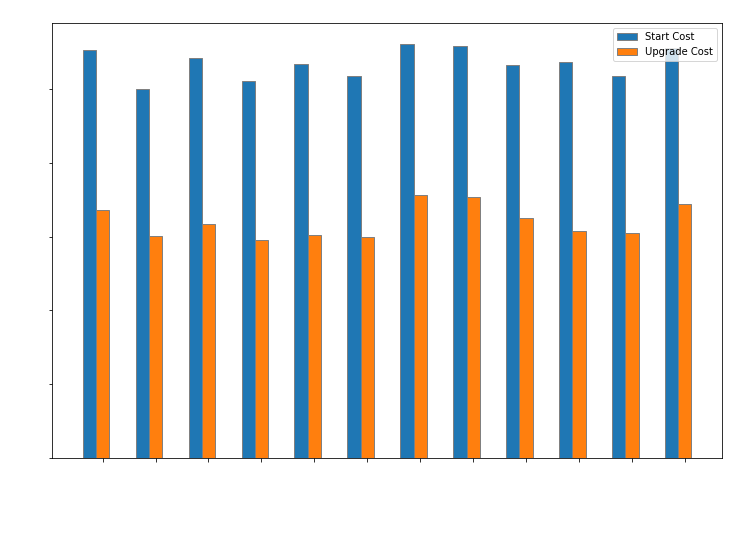

In [32]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
starting_cost = monthly_sums['start_total_cost'][:-1]
upgrade_cost = monthly_sums['upgrade_total_cost'][:-1]

 
# Set position of bar on X axis
br1 = np.arange(len(starting_cost))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, starting_cost, width = barWidth,
        edgecolor ='grey', label ='Start Cost')
plt.bar(br2, upgrade_cost,  width = barWidth,
        edgecolor ='grey', label ='Upgrade Cost')
 
# Adding Xticks
plt.xlabel('Month', fontweight ='bold', fontsize = 12, color = 'white')
plt.ylabel('Cost ($)', fontweight ='bold', fontsize = 15, color = 'white')
plt.xticks([r + barWidth for r in range(len(starting_cost))],
        ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December'])

plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')
plt.title('Monthly Gas and Elect Cost - ' + start + " vs. " + upgrade_only, fontweight = 'bold', color = 'white')
plt.legend()
plt.show()

In [33]:
### presenting natural gas pricing 

from prettytable import PrettyTable
table = PrettyTable()
column_names = ["Month", "Bills Pre Upgrade", "Bills After Upgrade"]
data_columns =[
     ['January', 'February', 'March', 'April', 'May','June','July','August','September','October','November','December','Total'],
    monthly_sums['start_total_cost'],
    monthly_sums['upgrade_total_cost']
    ]
# Add columns to the table
for name, data in zip(column_names, data_columns):
    table.add_column(name, data)

# Align columns to the left
for name in column_names:
    table.align[name] = "l"

# Format the salary column as dollars and cents
starting_column_index = column_names.index('Bills Pre Upgrade')
for row in table._rows:
    row[starting_column_index] = "${:.2f}".format(float(row[starting_column_index]))
    
# Format the salary column as dollars and cents
upgrade_column_index = column_names.index('Bills After Upgrade')
for row in table._rows:
    row[upgrade_column_index] = "${:.2f}".format(float(row[upgrade_column_index]))
    
# Add a horizontal line after the header row
table.horizontal_char = '-'

# Add a vertical line between columns
table.vertical_char = '|'

# Add an intersection character between the columns and the header row
table.junction_char = '+'

# Print the table
print(table)

+-----------+-------------------+---------------------+
| Month     | Bills Pre Upgrade | Bills After Upgrade |
+-----------+-------------------+---------------------+
| January   | $276.36           | $168.22             |
| February  | $249.73           | $150.52             |
| March     | $270.84           | $158.82             |
| April     | $255.34           | $147.67             |
| May       | $266.66           | $151.17             |
| June      | $259.14           | $149.82             |
| July      | $280.61           | $178.29             |
| August    | $279.21           | $176.53             |
| September | $266.02           | $162.92             |
| October   | $268.39           | $153.48             |
| November  | $259.14           | $152.34             |
| December  | $277.45           | $171.89             |
| Total     | $3148.21          | $1890.28            |
+-----------+-------------------+---------------------+


In [34]:
### calculating energy burden with total bill
income = inputs.iloc[6,1]
start_elec_cost = monthly_sums['start_total_cost'].iloc[12]
upgrade_elec_cost = monthly_sums['upgrade_total_cost'].iloc[12]
start_burden = start_elec_cost/income
upgrade_burden = upgrade_elec_cost/income
formatted_start_burden  = "{:.2%}".format(start_burden)
formatted_upgrade_burden = "{:.2%}".format(upgrade_burden)
print("Customer energy burden before upgrade is: " + formatted_start_burden + ".")
print("Customer energy burden after upgrade is: " + formatted_upgrade_burden + ".")

Customer energy burden before upgrade is: 6.30%.
Customer energy burden after upgrade is: 3.78%.
